# Wasserstein GAN

Wassertein GAN (WGAN) is a variant of the traditional GAN system, but attempt to solve some of the common problems that GANs face such as mode-collapse, training instability, and difficulty to balance the generator and discriminator. Lets quickly remind ourselves of the original GAN Formulation:

## GAN Loss Function
$$Loss = \min_G \max_D \mathbb{E}_{x\sim p_x(x)} \log(D(x)) +\mathbb{E}_{x\sim p_z(z)} \log((1-D(G(z)))$$

Our goal is to simulteously train a discriminator that maximizes this loss, which in effect maximizes the log-probability and makes a confident discriminator, and also minimize this loss by training a generator that can confidently fool the discriminator. Typically this loss function is jusy Binary Cross Entropy. 

The problem is, we are using the discriminator to update our generator. If our discriminator becomes really good, and with near 100% probability able to detect if an image is real or fake, then $(1-D(G(z)))$ will be close to 0, and the gradients flowing to our generator will then also be close to 0. 

### Earth Movers Distance

WGAN makes a change to use the Earth Movers distance as the loss rather than Binary Cross Entropy which provides more prominent gradients. The Earth Movers Distance is a measure of dissimilarity between two frequency densities. This metric comes from an area of study known as Optimal Transport. Optimal transport is the study of how we can move one distribution of mass to another while minmizing cost. When we apply the Earth Movers Distance to probability distributions, it is known as the Wasserstein distance.

Imagine you run a shipping company and need to figure out the logistics of how you can deliver packages from your warehouse to parts of the city. Lets say today you have 20 packages to deliver. You could randomly select houses to drive to, but you may end up driving back and forth around the city a lot. Instead you want to find the most optimal path to all the houses that minimize the total travel distance, time and gas used. 

Another cool application of Earth Movers Distance is for image retrieval. You can produce a feature vector for images that contain information like color, texture or basic structural features which acts as the distribution representing that image. We can then calculate the Earth Movers Distance between the vector of the image we want and all other images to see how much "effort" it would take to match the featue distributions, and the one with the lowest will be the most similar image to retrieve. 

### Example of The Earth Movers Distance

You can see a more clear example at this incredible [blog post](https://lilianweng.github.io/posts/2017-08-20-gan/) and ill be doing a similar example here:

Lets say we have the following discrete distributions:

$$P_1 = 1, P_2 = 2, P_3, = 5, P_4 = 3$$
$$Q_1 = 3, Q_2 = 1, Q_3, = 2, Q_4 = 5$$

To compute the cost, it is the amount moved multipled by the distance moved. The amount is the number (i.e. we want to move 1 from $P_2$ to $P_3$) and the distance moved is how many steps we moved it over (i.e $P_1$ to $P_2$ is a distance of 1 and $P_1$ to $P_3$ is a distance of 2)

Our goal is to move $P$ around to match $Q$, but you can imagine there are a bunch of ways to do this. For example:

#### Option 1:

- Move 2 from $P_2$ to $P_1$. $Q_1$ and $P_1$ now match up, and we incur a cost of 2 (amount moved) * 1 (distance moved) = 2

$$P_1 = 3, P_2 = 0, P_3, = 5, P_4 = 3$$

- Move 1 from $P_3$ to $P_2$. $Q_2$ and $P_2$ now match up, and we incur a cost of 1 (amount moved) * 1 (distance moved) = 1

$$P_1 = 3, P_2 = 1, P_3, = 4, P_4 = 3$$

- Move 2 from $P_3$ to $P_4$. Everything now matches up, and we incur a cost of 2 (amount moved) * 1 (distance moved) = 2

$$P_1 = 3, P_2 = 1, P_3, = 2, P_4 = 5$$

**TOTAL COST:** 5

#### Option 2:

- Move 2 from $P_2$ to $P_4$. $Q_4$ and $P_4$ now match up, and we incur a cost of 2 (amount moved) * 2 (distance moved) = 4

$$P_1 = 1, P_2 = 0, P_3, = 5, P_4 = 5$$

- Move 3 from $P_3$ to $P_2$. $Q_3$ and $P_3$ now match up, we incur a cost of 3 (amount moved) * 1 (distance moved) = 3

$$P_1 = 1, P_2 = 3, P_3, = 2, P_4 = 5$$

- Move 2 from $P_2$ to $P_1$. Everything now matches up, and we incur a cost of 2 (amount moved) * 1 (distance moved) = 2

$$P_1 = 3, P_2 = 1, P_3, = 2, P_4 = 5$$

**TOTAL COST:** 9

Both of these options are totally valid and will get us to our target distribution $Q$ and each option is typically known as transport plan. But as we see, **Option 1** incurrs less cost than **Option 2**, and therefore is the better plan!

### Moving to a Continuous Distribution 

The continuous case of this, applied to probability distributione now asks a similar question. How much of the mass from my distribution in $u$ do I need to move around to match it to $v$? We assume, like in all distributions, the total mass we are starting with is 1. Both distributions also lie in the same space, so lets say that space is $X$. Lets plot a simple example here of mapping some bimodial distribution to a standard normal distribution. 


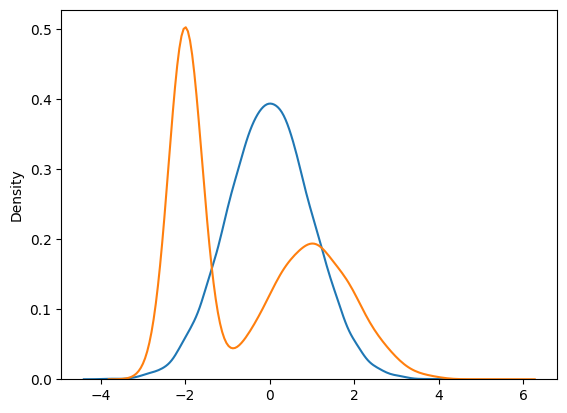

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

num_samples = 10000
target = np.random.normal(0, 1, num_samples)
data = np.concatenate([
    np.random.normal(-2, 0.3, num_samples // 2),
    np.random.normal(1, 1, num_samples // 2)
])

plot = sns.kdeplot(target, label='Target')
plot = sns.kdeplot(data, label='Data')
plt.show()

### Get the lines so we have the distributions ###
target_x, target_y = plot.lines[0].get_data()
data_x, data_y = plot.lines[1].get_data()



The cost of moving mass from point $x$ to point $y$ is $c(x,y) > 0$. The selected transport plan to move from $u$ to $v$ is known as $\gamma(x,y)$ which gives how much should we move from $x$ to $y$? Another way to think about this though is, think about $u$ as a mount of dirt, and invert $v$ to be a hole in the ground. The amount of dirt in $u$, and the hole in $v$ are the exact same size of 1. Then we need to take dirt from $u$ and fill $v$ with it. Once we have filled $v$, we have completed our transport, and the way we moved the dirt is defined by the transport plan.

There is a great package called ```ot``` that can plot the optimal transport matrix, identifying $\gamma$ and how we can optimally move mass from one distribution to another. 

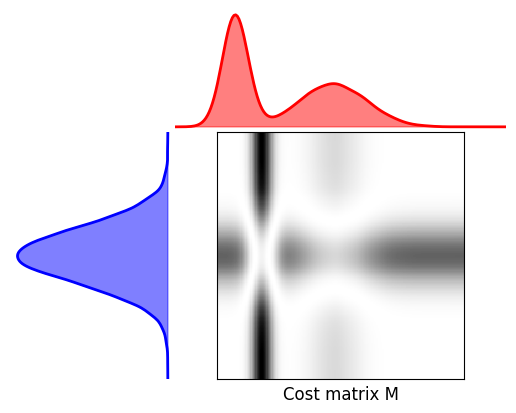

In [2]:
import ot
import ot.plot 

M = ot.dist(target_y.reshape((-1, 1)), data_y.reshape((-1, 1)))
M /= M.max()

ot.plot.plot1D_mat(target_y, data_y, M, "Cost matrix M")
plt.show()

There are some restrictions though on our transport plan though for this to all make sense. 

1. The amount of mass we take out at point $x$ must match the amount of mass that was in our original distribution $u$. Therefore, if we integrate our transport over all the $y$ for some given $x$, we will end up with the amount of dirt that was originally in that spot $x$. Basically, our dirt that was in spot $x$ in distribution $u$ has been redistributed across all potential spots in $v$ indicated by $y$.

$$\int \gamma(x,y)dy = u(x)$$

2. The total mass going into $y$ must match the target distribution $v$. Remember, in our analogy, $v$ is a hole, and we are taking from $u$ and placing into different points $y$ along $v$. Therefore, once our hole is full, taking in dirt from different points in $x$ into a specific point $y$, the total dirt at that point $y$ must match whatever the depth of the hole was at that point $y$ which is defined by $v$

$$\int \gamma(x,y)dx = v(y)$$

Therefore, $\gamma(x,y)$ is just a joint distribution with marginals $u$ and $v$

#### Overall Cost of a Transport Plan 
The transport plan of how much to move from $x$ to another point $y$ is $\gamma(x,y)$ and the cost it incurrs is $c(x,y)$, therefore, our total cost can by their product just as we had done earlier, just summed (or integrated) over all possible $x,y$ combinations:

$$\int\int c(x,y)\gamma(x,y)dxdy$$

#### Optimal Plan
As we saw earlier, the plan is not unique. There are lots of ways to shovel dirt! To find the optimal plan, we need to find one that minimizes our cost.

$$W(u,v) = \inf_{\gamma \in \Pi(u,v)} E_{(x,y) \sim \gamma}[c(x,y)]$$

Where:

- $\Pi(u,v)$ is the set of all possible transport plans
- $\gamma \sim \Pi(u,v)$ is a single one of those transport plans
- $c(x,y)$ is the cost, but typically we use a distance metric for our cost function

Assuming some kind of a Euclidean distance, we can then write our final distance formula as:

$$W(u,v) = \inf_{\gamma \in \Pi(u,v)} E_{(x,y) \sim \gamma}[||x-y||]$$

### Wasserstein vs Jensen-Shannon Divergence 

We proved in our [Intro to Gans](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20for%20Generation/Generative%20Adversarial%20Network/Intro%20to%20GANs) that the optimal solution to our traditional GAN can be represented in terms of the Jensen-Shannon Divergence.

$$-2\log(2) + 2 * D_{JS}(p_{data} || p_g)$$

But this may have have some problems regarding the smoothness of our function for nice gradient calculations. The [WGAN paper](https://arxiv.org/pdf/1701.07875) has an example called parallel lines that makes this clear, so lets take a look at it!

Let $Z \sim U(0,1)$, a uniform distribution. We then create two joint distributions $P ~ (0,Z)$ and $Q ~ (\theta, Z)$. This is basically two verical lines, one at 0 and another at $\theta$.

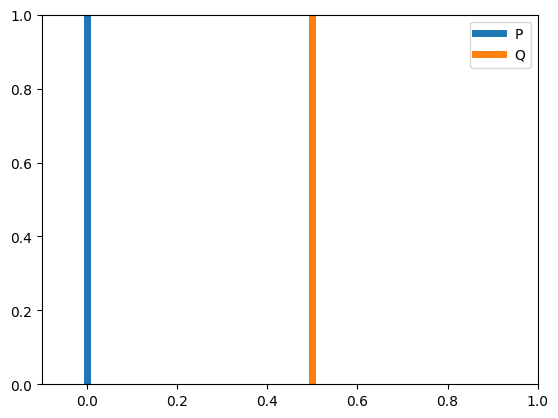

In [3]:
num_samples = 200
theta = 0.5

unif = np.random.uniform(size=(num_samples))

plt.plot(np.array([0 for _ in range(num_samples)]), unif, label="P", linewidth=5)
plt.plot(np.array([theta for _ in range(num_samples)]), unif, label="Q", linewidth=5)
plt.ylim(0,1)
plt.xlim(-0.1,1)
plt.legend()
plt.show()

Notice that, as long as $\theta$ doesnt equal to 0, these vertical lines will never touch! Lets now compute our Jensen Shannon Divergence. 

### Jensen Shannon When $\theta \neq 0$

The formula for the Jensen Shannon Divergence was the average of the KL Divergence in both directions:

$$D_{JS}(Q||P) = \frac{1}{2}D_{KL}(Q||M) + \frac{1}{2}D_{KL}(P||M)$$ 

where:

$$M = \frac{Q+P}{2}$$

$$D_{KL}(A||B) = \int A(x_i) \cdot \log \frac{A(x_i)}{B(x_i)}$$

#### First step, lets compute $M$!

At $x=0$, $P(x) = 1 \text{ and } 0 \text{ elsewhere}$ 

At $x=\theta$, $Q(x) = 1 \text{ and } 0 \text{ elsewhere}$ 

Basically, when $x=0$, all the probability is along the line, so $P(x) = 1$ for everything along the line. On the other hand, for all other $x$. there is no density at all (the vertical line is just at 0) so $P(x) = 0$ This is the same for $Q$, but its line is at $\theta$, and there is no other density elsewhere.

Well, this should remind you of the Dirac Delta Function! The Dirac function $\delta(x)$ is 1 when the argument of the delta function is 0, and 0 elsewhere. Therefore we can write:

$$P(x) = \delta(x)$$
$$Q(x) = \delta(x-\theta)$$

$$M = \frac{P + Q}{2} = \frac{\delta(x) + \delta(x-\theta)}{2} = \frac{1}{2} \text{ if } x \neq \theta$$

Then we can calculate our Jensen Shannon Divergence as the following:

$$D_{JS}(P||Q) = \frac{1}{2}D_{KL}(P||M) + \frac{1}{2}D_{KL}(Q||M)$$ 
$$=  \frac{1}{2} \int P \cdot \log \frac{P}{M}  + \frac{1}{2} \int Q \cdot \log \frac{Q}{M}$$ 
$$=  \frac{1}{2} \int \delta(x) \cdot \log \frac{\delta(x)}{\frac{1}{2}}  + \frac{1}{2} \int \delta(x-\theta) \cdot \log \frac{\delta(x-\theta)}{\frac{1}{2}}$$ 

In the first term: $$\frac{1}{2} \int \delta(x) \cdot \log \frac{\delta(x)}{\frac{1}{2}}$$ because of the product with $\delta(x)$, this integral only exists at $x=0$ and 0 elsewhere. So we can simplify it to $$\frac{1}{2} \cdot \log \frac{\delta(x)}{\frac{1}{2}}$$ Because this integral only existed $x=0$, we can evaluate $\delta(x)$ at 0, which is just 1, giving us the final $$\frac{1}{2} log(2)$$

In the second term $$\frac{1}{2} \int \delta(x-\theta) \cdot \log \frac{\delta(x-\theta)}{\frac{1}{2}}$$ this integral only exists at $x=\theta$ and 0 elsewhere. So we can simplify it to $$\frac{1}{2} \cdot \log \frac{\delta(x-\theta)}{\frac{1}{2}}$$ Because this integral only existed $x=\theta$, we can evaluate $\delta(x=\theta)$ at $\theta$, which is just 1, giving us the final $$\frac{1}{2} log(2)$$


Thus, the final Jensen Shannon Divergence can be written as $$\frac{1}{2} log(2) + \frac{1}{2} log(2) = log(2)$$

On the other hand, if $\theta = 0$, then our two vertical lines are identical, and our divergence would just be 0. Therefore:


\begin{equation}
  D_{JS}(P,Q) =
    \begin{cases}
      \log2 & \text{if } \theta \neq 0  \\
      0 & \text{else}\\
    \end{cases}       
\end{equation}

### Wasserstein Distance for Vertical Lines

To compute the cost of transport from the vertical lines, is just to shift our line over from $\theta$ to 0. Therefore the wasserstein distance is just $|\theta|$ **ALWAYS**.

\begin{equation}
  W(P,Q) = |\theta|    
\end{equation}

### Stability

Notice the difference in stability in training. The Wasserstein distance provides a smooth measure that is nicely differentiable at all $\theta$. On the other hand The Jensen Shannon jumps from 0 to $\log 2$ which may hurt gradient optimization methods like the ones we use to train Neural Networks!

### Wasserstein Distance for GAN Training ###

Now that we understand the Wasserstein distance, what can we do with it? Well lets start relating this all back to GANs. In a GAN we have two distributions, the real data distribution $P_r$ and the generated data distribution $P_g$ and we want these to be as close as possible. So we can rewrite our Wasserstein distance in terms of them:

$$W(P_r,P_g) = \inf_{\gamma \in \Pi(P_r,P_g)} E_{(x,y) \sim \gamma}[||x-y||]$$

We are trying to find the optimal transport plans, but this means optimizing over a set of joint distributions $\Pi(P_r,P_g)$. Even more challenging is, we don't know what $P_r$ and $P_g$ are! In comes some fancy math!! The ```Kantorovich-Rubenstein Duality Theorem```. This is a key mathematical result that can convert the intractable Wasserstein distance from its primal form into its dual. 

### Quick Recap on Primal vs Dual

If you haven't taken an optimization course you may not have heared of this but primal and dual forms refer to constrained optimization. I am not a super mathematician who can give you all the nitty gritty details on this, there are better resources out there, but I can give the high level idea with an example!

$$\min f(x,y) = x^2 + y^2$$
$$\text{where } x + y = 2$$

This is a very typical constrained optimization problem. We know that $f(x,y)$ is minimum at $(0,0)$ with a value of $0$ but this does not satisfy our constraint of $x + y = 2$ Lets take a look graphically what this may look like

<img src="src/constrained_optimization.png" alt="drawing" width="300"/>

As you can see, $f(x,y) = x^2 + y^2$ is basically a parabola in 2d, and our solution must be at the intersection of this 2d parabola and our plane where $x + y = 2$

#### Primal

First up is the primal form, which is typically just the original problem we want to solve. In this case, the primal is super easy to calculate. In other cases (looking at you SVM) the primal may not be feasible at all. So lets go ahead and solve this exactly how you normally would!

$$\text{let } y = 2 - x$$
$$f(x,y) = x^2 + y^2 = x^2 + (2-x)^2 = 2x^2 - 4x + 4$$

Now that we have our function (just in terms of $x$) go ahead and take the derivative and set to 0 to minimize:

$$\dfrac{df}{dx}f(x,y) = 4x - 4 = 0$$
$$\therefore x = 1 \text{ and } y = 1$$

The minimum that our function can be is at $f(x,y) = 2$

#### Lagrange Multipliers

To compute the Dual, we first need to calculate using the Lagrange Multiplier. Basically, the Lagrange Multiplier is a technique to take a constrained optimization problem, rewrite it all as one equation, and add more parameters to optimize.

[Here](https://medium.com/@andrew.chamberlain/a-simple-explanation-of-why-lagrange-multipliers-works-253e2cdcbf74) is a really amazing article about lagrange multipliers written by Andrew Chamberlain, that I would recommend if you have never seen this before! But here is the main idea (using a really helpful figure from the article!):

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/0*pLw-66xQVUJwYryA.jpg" alt="drawing" width="300"/>

Lets first discuss the notation:

- $f(x_1,x_2)$ is the function we want to optimizer (in this case we are maximizing instead of minimizing)
- $g(x_1,x_2)=c$ is a constraint, basically we cannot go higher than that point on this hill
- $f=a_1, f=a_2$ are just 2 level curves, but there are obviously infinite possible curves.

Lets say you are ascending the hill, there are actually two gradients that you can calculate:

- $\Delta f$ which is the path of steepest ascent on our hill in general (doesn't care about constraints). These gradients are also always perpendicular to the level curves at that point where the derivative is being taken.
- $\Delta g$ which is the derivative of our constraint function evaluated at where we are currently standing

Instead of just randomly ascending the hill now, instead lets ascend by following the constraint line (the intersection of our function and our constraint). Our solution must be somwhere on this constraint, so it makes sense to just look along there. As you move along the constraint line you will be computing what is your derivative with respect to the hill $\Delta f$ to know the direction that ascends, and then the derivative of your constraint. 

If you notice at the very top of your constraint (indicated with the dark arrow) something special happens. The direction of greatest change of the constraint points in the same direction as the derivative of our function! They may not be equal (different magnitudes) but they are pointing in the same direction. Therefore, at the ideal point, it must be true that our gradients of the function and the constraint must be parallel, but not necessarily equal. We can then write this as:

$$\Delta f = \lambda \Delta g$$

Basically, wherever this condition is met, where our $$\Delta f \text{ and } \Delta g$$ point in the same direction (differing by some scalar factor), we have our optimal point! Typically we see this written as:

$$\Delta f - \lambda \Delta g = 0$$

Therefore our final setup with lagrange multipliers would be:

$$L(x,\lambda) = f(x) - \lambda g(x) $$

Where $f(x)$ is the function we want to solve with the constraint of $g(x)$. And instead of optimizing over $x$ only, we need to also optimize over $\lambda$. 

Because $\lambda$ has to be optimized, it actually doesn't matter if we are positive or negative, so you can also see these multipliers written with the sign flipped:

$$L(x,\lambda) = f(x) + \lambda g(x) $$

**NOTE**:

I assume $g(x)$ to be a equality constraint. You can also have inequality constraints, and then you get to work with [KKT](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions) conditions but that is going too far for our goal of deriving the Wasserstein Loss. 

#### Dual

So lets do this first, lets rewrite our constraint like the following:

$$x + y - 2 = 0$$

And we can now write our new expression like the following:

$$L(x,y,\lambda) = x^2 + y^2 + \lambda(x+y-2)$$

The Dual of an optimization problem is typically written as the following:

$$\text{Dual: }q(\lambda) = \inf_{x,y}L(x,y,\lambda)$$

We use $\inf_{x,y}$ instead of $\min$ because $\inf_{x,y}$ means we want the greatest lower bound possible. We may not be able to totally minimize, so its a little less strict than just $\min$. To get it though, we do what we always do! Take the derivative of $L(x,y,\lambda)$ w.r.t $x$ and $y$.

$$\dfrac{dL}{dx} = 2x + \lambda = 0$$
$$\dfrac{dL}{dy} = 2x + \lambda = 0$$

Therefore we can write
$$x = -\lambda / 2$$
$$y = -\lambda /2$$

Now technically, we already know that the ideal $(x,y)$ was $(1,1)$, so we could just say $\lambda = -2$, but lets keep going!

And plug back into our original equation:

$$q(\lambda) = (\frac{-\lambda}{2})^2 + (\frac{-\lambda}{2})^2 + \lambda(-\frac{\lambda}{2} - \frac{\lambda}{2} -2)$$
$$= -\frac{\lambda^2}{2} - 2\lambda$$

So notice, our Dual is only in terms of Lambda! Basically, going from $L(x,y,\lambda)$ to $q(\lambda)$ was, for some fixed $\lambda$, what was the lowest we can go (the highest lower bound). Now its time to optimize $\lambda$, and we will be maximzing it! The way I think about this is:

- $q(\lambda)$ is a function telling us what is the smallest $L(x,y,\lambda)$ for some given $\lambda$
- By now maximizing w.r.t $\lambda$ we are enforcing the constraint. $\lambda$ tells us how sensitive the function is to the constraint and acts as a tradeoff between the objective function and our constraint. It acts as pressure to ensure our optimization problem doesn't violate the constraint, but we have to calibrate exactly how much pressure we need. (This is not 100% whats happening but should provide the intuition so dont get mad all yall optimization people!)

So, lets go ahead and do the following:

$$\sup_{\lambda} q(\lambda)$$

Again, this optimization may not be perfect and find the absolute max, so we instead want the lowest upper bound possible (a looser definition). In our case this is again simple, take the derivative and set to 0!

$$\dfrac{dq}{d\lambda} = -\lambda - 2$$
$$\therefore \lambda = -2$$

$$q(\lambda=-2) = -(\frac{(-2)^2}{2}) - 2(-2) = 2$$

So again, we find that our minimum is 2! Same answer as our previous method using the primal but slightly different methods. 

##### TLDR:

- The minimization of our primal looks for the lowest possible value for $f(x)$ constrained by our $g(x)$.
- The maximization of our dual is the maximization of our lowest bound. Sure $q(\lambda)$ may provide a lower bound for our minimum, but in most cases this lower bound is bad! Lets look at a plot showing the primal (blue) and dual (red):

<img src="src/primal_dual.png" alt="drawing" width="450"/>

Notice that at $x=1$ we minimize our primal (and then by our constraint $y=1$ as we solved earlier). Also notice we maximize our dual at $\lambda=-2$. And the effective min or our primal and max of our dual are identical!

Now what if we picked a different value for $\lambda$? Remember, the dual is our lower bound to the primal, but this lower bound can also be useless. For example, lets say we picked a $\lambda$ where our dual is negative. Well first of all, our objective function is a quadratic parabola always greater than 0. So sure, a negative dual does technically lower bound it (as it can never be less than 0 anyway), but is that useful? Probably not. 

So this visual shows why we maximize our dual. The dual just gives the lower bound, but we want an actually useful lower bound, so we max and hopefully it provides more information. 

#### Strong vs Weak Duality

So as we saw, the primal wants the minimum value of an objective function under some constraints. The dual converts this to a maximization problem of a new lagrangian multiplier function. We typically call the results of the primal as $p^*$ and the results of the dual $d^*$. And in the case of the simple problem we solved, these both came to be identical, but this may not always be the case:

**Weak Duality**

Weak Duality is a property that holds of **ALL** primal/dual pairs. This is that the optimal value of the Dual is always less than or equal to the optimal value of the primal. Basically $d^* \leq p^*$. (we are thinking of minimizing our objective function, if we max everything flips but the idea is the same!)

Because $d^* \leq p^*$, we maximize to find our highest $d^*$. Unfortunately, there may be a gap between the lowest primal and the highest dual. The dual is just a lower bound, this lower bound does not necessarily reach the primal solution. Therefore this is known as the **Duality Gap**. 

**Strong Duality** 

In some scenarios, there is no gap! The max of the dual is the min of our primal, and we saw this in the example we did. The min of our primal gave us the max of our dual. Therefore Strong Duality is when $d^* = p^*$

### Converting the Wasserstein Distance Primal to Dual (Kantorovich-Rubenstein Duality Theorem)
$$W(p,q) = \inf_{\gamma \in \Pi(p,q)} E_{(x,y) \sim \gamma}[||x-y||]$$

Where we can express our expected value as the double integral over the transport plan

$$E_{(x,y) \sim \gamma}[||x-y||] = \int\int|x-y|\gamma(x,y) dxdy$$

Ok, now it will get more challenging. This derivation is very close to a [reference](https://courses.cs.washington.edu/courses/cse599i/20au/resources/L12_duality.pdf) by John Thuckstun, so please go there for more details!

Like we talked about, our Wasserstein distance is intractible, but if we find is dual, we can then identify atleast a lower bound to this distance. So, this is a constrained optimization problem, but what are the constraints? The marginals of the transport plan need to be the target and source distributions!

$$\int \gamma(x,y)dy = p(x)$$

$$\int \gamma(x,y)dx = q(y)$$

Ok so one more complexity then, we talked about equality constraints. If we had some problem:

$$\min f(x)$$
$$\text{where } g(x) = 0$$

Then we easily set up our Lagrangian as the following:

$$L(x,\lambda) = f(x) + \lambda g(x)$$

What if we have multiple constraints?
$$\min f(x)$$
$$\text{where } g(x) = 0$$
$$\text{where } h(x) = 0$$

Then similarly, we set up our lagrangian with two lagrange multipliers

$$L(x,\lambda) = f(x) + \lambda_1 g(x) + \lambda_2 h(x)$$



But in our case, our equality constraint isn't to some constant, its to a function? Well its the same thing! Instead of some constant 
$\lambda$ we will have some function $a(x)$ of our lagrangian multipliers. And instead of adding each multipler to our constraint, we integrate as its the continuous case. Therefore we can rewrite our constraints as:

$$p(x) - \int \gamma(x,y)dy = 0$$

$$q(y) - \int \gamma(x,y)dx = 0$$

And we will use the lagrange multiplier functions $f(x)$ and $g(y)$ respectively. This gives us our function:


$$L(\gamma, f, g) = \int\int|x-y|\gamma(x,y) dxdy + \int\left[p(x) - \int \gamma(x,y)dy\right]f(x)dx + \int\left[g(y) - \int \gamma(x,y)dx\right]g(y)dy$$

We can now rewrite:

$$\int\left[p(x) - \int \gamma(x,y)dy\right]f(x)dx$$ 
$$= \int p(x)f(x)dx - \int\int \gamma(x,y)f(x)dxdy$$ 

where:

$$\int p(x)f(x)dx = E_{x \sim p}[f(x)]$$

Similarly:

$$\int\left[q(y) - \int \gamma(x,y)dx\right]g(y)dy$$ 
$$= \int q(y)g(y)dy - \int\int \gamma(x,y)g(y)dxdy$$ 

where:

$$\int q(y)g(y)dy  = E_{y \sim q}[g(y)]$$

So putting it all together:

$$L(\gamma, f, g) = \int\int|x-y|\gamma(x,y) dxdy + \int\left[p(x) - \int \gamma(x,y)dy\right]f(x)dx + \int\left[g(y) - \int \gamma(x,y)dx\right]g(y)dy$$

$$ = \int\int|x-y|\gamma(x,y) dxdy + \int p(x)f(x)dx - \int\int \gamma(x,y)f(x)dxdy + \int q(y)g(y)dy - \int\int \gamma(x,y)g(y)dxdy$$
$$ = \int\int|x-y|\gamma(x,y) dxdy + E_{x \sim p}[f(x)] - \int\int \gamma(x,y)f(x)dxdy + E_{y \sim q}[g(y)]- \int\int \gamma(x,y)g(y)dxdy$$

And grouping all the itegrals together we get:

$$L(\gamma, f, g) = E_{x \sim p}[f(x)] + E_{y \sim q}[g(y)] + \int\int(|x-y| - f(x) - g(y))\gamma(x,y) dxdy$$

So now that we have our lagrangian setup, its time to find the dual $q(f,g) = \inf L(\lambda, f, g)$

Instead of $min$ though, we technically have to do an $argmin$ at this stage. The reason is $\lambda$ is one of many transport plans, so its enumerated. 

So if we want to minimize $L(\gamma, f, g)$ lets see what we can do, as this isn't exactly differentiable. 

The terms $E_{x \sim p}[f(x)], E_{y \sim q}[g(y)]$ have nothing to do with our transport plan $\lambda$ so they are constants. So in this minimization we can ignore them for now. 

In our last term:

$$ \int\int(|x-y| - f(x) - g(y))\gamma(x,y)$$

We basically have two options here:

if $|x-y| < f(x) + g(y)$, our $L$ will just go to $-\infty$ This is because $f(x) + g(x)$ can just continue to get larger and larger during optimization for the lagrangian, so thats not very helpful. What about our other option?

if $|x-y| \geq f(x) + g(y)$, we know $|x-y|$ can be at the smallest 0 and so the difference can only go to 0. Well if its going to be 0 anyway, then why not make our life easier and just set $\gamma(x,y)$ to 0?

This means all we are left with now for our dual is:

$$q(f, g) = E_{x \sim p}[f(x)] + E_{y \sim q}[g(y)]$$

with the restriction that $|x-y| \geq f(x) + g(y)$

Now, just like before, we need to maximize w.r.t $f$ and $g$ to find the higest lower bound! So we are now working with:

$$W(p,q) = \sup_{|x-y| \geq f(x) + g(y)}E_{x \sim p}[f(x)] + E_{y \sim q}[g(y)]$$

The annoying part is, our function has two things to still optimize over, $f$ and $g$, can we somehow represent this all as a single variable?

So, lets first jump to the end, what do we want?

$$W(p,q) = \sup_{|x-y| \geq h(x) - h(y)}E_{x \sim p}[h(x)] - E_{y \sim q}[h(y)]$$

Can we somehow write this all in terms of a single variable $h$? Lets see!

First, what can we do with $E_{x \sim p}[h(x)] - E_{y \sim q}[h(y)]$?

$$E_{x \sim p}[h(x)] - E_{y \sim q}[h(y)]$$
$$= \int h(x)p(x)dx - \int h(y)q(y)dy$$
$$= \int h(x)\int\gamma(x,y)dxdy - \int h(y)\int\gamma(x,y)dxdy$$
$$= \int\int (h(x) - h(y))\gamma(x,y)dxdy$$

Our restriction was specifically that $h(x) - h(y) \leq |x-y|$ This then implies that:

$$\int\int (h(x) - h(y))\gamma(x,y)dxdy \leq \int\int |x-y|\gamma(x,y)dxdy = W(p,q)$$

Therefore, we have shown that this new function we created with $h$ is a valid lower bound of the of our target function $W(p,q)$! Remember, our first step was to find the min, and get the highest lower bound possible and then maximize that. Well, if $h$ acts as a lower bound to $W$, we can use this as our lowerbound without any issues! (You can think about this like, we found a lower bound to a lower bound). All we have to show now that when we maximize and take the $\sup_{|x-y| \geq h(x) - h(y)}E_{x \sim p}[h(x)] - E_{y \sim q}[h(y)]$ is an upper bound for $\sup_{|x-y| \geq f(x) + g(y)}E_{x \sim p}[f(x)] + E_{y \sim q}[g(y)]$. if this is true, then we are done. 

##### Infimal Convolution

This part of the derivation is probably the toughest part. I have personally never heared of this, but it is being used. I wont go into any depth about the Infimal Convolution and just directly  use it. 

$$\kappa(x) = \inf_u [|x - u| - g(u)]$$

Basically, from what I gather, you are doing the sum on all possible $u$ and then picking the one that minimizes it for some target function. Either way, lets just keep moving!

#### 1-Lipschitz

For something to be 1-Lipschitz, it means the rate of change is bounded by the change itself. For example, when we said earlier that $|x-y| \geq h(x) - h(y)$, this meets the condition, as the rate of change in the function $h$ is bounded by the change in the input itself. The reason it is 1-Lipschitz is because $|x-y| \geq h(x) - h(y)$, a 2-Lipschitz would be $2 * |x-y| \geq h(x) - h(y)$. Basically just a scaling constant. The main idea is that it must be true for all $x,y$.

Now, if $\kappa(x) = \inf_u [|x - u| - g(u)]$, then $\kappa(x)$ must be less than or equal to all $[|x - u| - g(u)]$ for all $u$. So we can write:

$$\kappa(x) \leq [|x - u| - g(u)]$$

Lets now introduce a $y$ as such:

$$|x-y| + |y-u|$$

By the triangle inequality, $|a + b| < |a| + |b|$, so similarly:

$$|x-y + y -u| = |x-u| < |x-y| + |y-u|$$

Therefore we can write:

$$\kappa(x) \leq |x - u| - g(u) \leq |x-y| + |y-u| - g(u)$$

But this inequality is true for all $u$, which means it must also be true for the $u$ that makes the smallest $|y-u| - g(u)$. Therefore we can write this in the Infimal Convolution notation again:

$$\kappa(x) \leq |x-y| + |y-u| - g(u)$$

$$\kappa(x) \leq |x-y| + \inf_u[|y-u| - g(u)]$$

$$\kappa(x) \leq |x-y| + \kappa(y)$$

Therefore, we get our 1-Lipschitz condition again!:

$$\kappa(x) - \kappa(y) \leq |x-y|$$

Now going back to our original restriction we set up:

$f(x) + g(y) \leq |x-y|$

This holds true for all $x$ and $y$, so lets just do a substition for $x=v$. For all $v$:

$$f(v) + g(y) \leq |v-y|$$
$$f(v) \leq |v-y| - g(y)$$

This is true for all $v$, then it must also be true for any $y=u$ that minimizes the function: 

**Note** Technically dont need all these variable substituions, just trying to make it close to the reference!

$$f(v) \leq \inf_u[|v-u| - g(u)]$$

And therefore, we can write this in terms of $\kappa$:

$$f(v) \leq \inf_u[|v-u| - g(u)] = \kappa(v)$$

so $u$ is when its smallest, but we dont really care, we are looking for bounds. If $f(v) \leq \kappa(v)$ for all $u$, then if we just set $u=v$ its technically still true. In $\inf_u[|v-u| - g(u)] \leq |v-v| - g(v)$. $u$ picked out the definitive minimum. If we pick something other than $u$ like $v$, then the new value can at the least be the same or greater. 

Therefore:
$$\inf_u[|v-u| - g(u)] \leq |v-v| - g(v) = -g(v)$$

And so we can finally write:
$$f(v) \leq \kappa(v) \leq -g(v)$$

So we can write (by substituting in our orignal $x$ and $y$ and reorganizing:

$$f(x) \leq \kappa(x)$$
$$g(y) \leq -\kappa(y)$$

Add it all together and take the expected value:

$$E[f(x)] + E[g(y)] \leq E[\kappa(x)] - E[\kappa(y)]$$

Wait, isnt that what we wanted? We wanted to show that $E_{x \sim p}[h(x)] - E_{y \sim q}[h(y)]$ is an upper bound for $E_{x \sim p}[f(x)] + E_{y \sim q}[g(y)]$. And we did! Its just that $h$ is our $\kappa$!!

If this is always true:
$$E[f(x)] + E[g(y)] \leq E[h(x)] - E[h(y)]$$

Then it must also be true for when we take the max:
$$\sup_{f(x) + g(y) \leq |x-y| }E[f(x)] + E[g(y)] \leq \sup_{h(x)-h(y) \leq |x-y|}E[h(x)] - E[h(y)]$$

### Relate to Wasserstein GAN

We now have the final dual form for the Wasserstein Metric, lets go ahead and create our loss function for the WGAN!

#### Discriminator (Critic)
The Wasserstein GAN is the same as before, we have a generator and discriminator and our loss can be written as:

$$L_{WGAN} = E_{x\sim real}[D(x)] - E_{x\sim gen}[D(x)]]$$

The Discriminator wants to maximize this, and increase the distance between the distribution of real and generated images. This means it wants to assign high values to the real images and low values (or negative) to the fake images. Therefore we can write this as:

- Maximize $E_{x\sim real}[D(x)]$
- Minimize $E_{x\sim gen}[D(x)]$

Now because we want to maximize, this that is the same as minimizing its negative, so we will be doing $E_{x\sim gen}[D(x)]] - E_{x\sim real}[D(x)]$

#### Generator 
The generator wants to do the opposite and reduce the discriminators ability to distinguish between real and fake images. So we will pass the discriminator generated images and move it in the direction that pushes generated values higher (opposite to the discriminator)

- $L_G = -E_{x\sim gen}[D(x)]$

$$\min_D\max_G L_{WGAN}$$

The only extra part is that, we need to ensure is the function that is learned is Lipschitz Continuous. 

If you have gotten this far, the hard part is over. Implementing this isn't too bad, but I thought the math was fun so I wanted to show it! Again, here are all the references I used:

[Lilian Weng](https://lilianweng.github.io/posts/2017-08-20-gan/#use-wasserstein-distance-as-gan-loss-function)

[John Thuckstun](https://courses.cs.washington.edu/courses/cse599i/20au/resources/L12_duality.pdf)

[Vincent Herrmann](https://vincentherrmann.github.io/blog/wasserstein/)

They have much more detail (and the background) to explain in more granularity, this was just my attempt to consolidate it all!

### Lets Implement it! 

This is not going to look all that different from our previous GAN implementations, except for adding in our 1-Lipschitz Continuous constraint and a few other details:

#### 1-Lipschitz Constraint
The Lipschitz Continuous constraint says that our functions rate of change must remain bounded, although not much more detail than that. 

The bound was as seen:

$$D(x)-D(y) \leq |x-y|$$

Well, the rate of change is controlled by the weights right? If we are doing linear regression, a function with larger weights will have a larger slope, so basically, we need to make sure our weights stay small. Well we know a few ways to keep our weights small, one them them being weight penalty (regularization). Although this could work, it is not an enforcement, but rather a recommendation to the model. Weight penalty only recommends to the model to keep the weights small, but it may not depending on what reduces the loss the most. So we instead do the Lipschitz Continuous condition in the dumbest way possible, Weight Clipping. After updating the weights of our Discriminator, we will just manually clip all the weights between some range. In the original WGAN paper, the clipping range was selected as [-0.01 to 0.01]

#### Optimizer

The paper saw that momentum based optimizers (like ADAM) provided poor and unstable results. They opt to use RMSProp instead!

#### N_Critic

It is important for the Critic (discriminator) to be able to learn the distribution of the current generator before we update the generator again. So in this case, we will be training the critic (updating it) more often than the generator. In the paper they use a 5:1 ratio, so for a given generator, the discriminator will get 5 update steps.


In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim 

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Write Model

Our Generator/Discriminator will be identical to before from our [DCGAN](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20for%20Generation/Generative%20Adversarial%20Network/DCGAN)

In [5]:
class Generator(nn.Module):
    def __init__(self, 
                 out_channels=3,
                 in_channels_latent_dim=100):
        super().__init__()

        self.out_channels = out_channels
        self.latent_dim = in_channels_latent_dim
        
        self.generator = nn.Sequential(

            ### (B x 100 x 1 x 1) -> (B x 1024 x 4 x 4) ###
            nn.ConvTranspose2d(self.latent_dim, 1024, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            ### (B x 1024 x 4 x 4) -> (B x 512 x 8 x 8)###
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            ### (B x 512 x 8 x 8) -> (B x 256 x 16 x 16) ###
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.ReLU(),

            ### (B x 256 x 16 x 16) -> (B x 128 x 32 x 32) ###
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            ### (B x 128 x 32 x 32) -> (B x 3 x 64 x 64) ###
            nn.ConvTranspose2d(128, self.out_channels, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )

        self.apply(_init_weights)
        
    def forward(self, x):
        return self.generator(x)

class Discriminator(nn.Module):
    def __init__(self,
                 in_channels=3):
        super().__init__()

        self.discriminator = nn.Sequential(

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0),
        )

        self.apply(_init_weights)

    def forward(self, x):
        batch_size = x.shape[0]
        return self.discriminator(x).reshape(batch_size,1)         

def _init_weights(module):
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(module.weight, 0.0, 0.02)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

### Training Parts

In [6]:
latent_dimension = 100
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 200
weight_clip_range = 0.01

generator_learning_rate = 0.00005
discriminator_learning_rate = 0.00005

### Define Models ###
generator = Generator(out_channels=1, in_channels_latent_dim=latent_dimension).to(device)
discriminator = Discriminator(in_channels=1).to(device)

### Define Optimizers ###
gen_optimizer = optim.RMSprop(generator.parameters(), lr=generator_learning_rate)
disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=discriminator_learning_rate)

### Define Datasets ###
tensor2image_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainset = MNIST("../../../data", transform=tensor2image_transforms)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

## WGAN Training w/ Clipping

  0%|          | 0/200 [00:00<?, ?it/s]

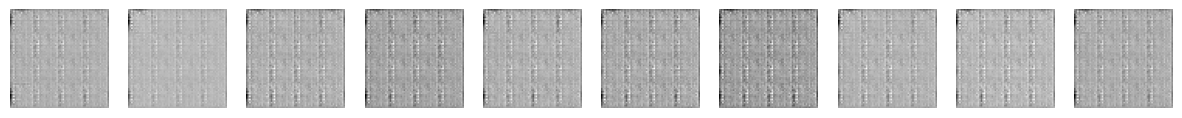

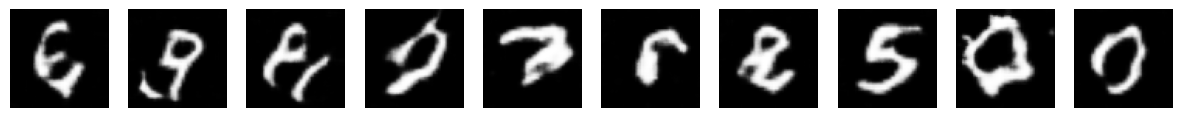

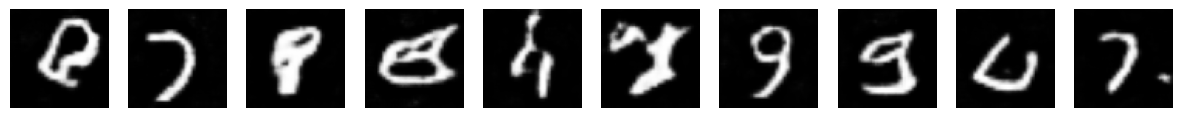

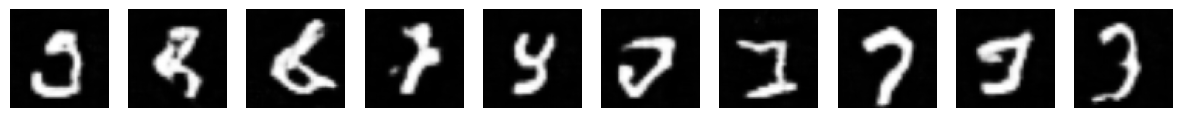

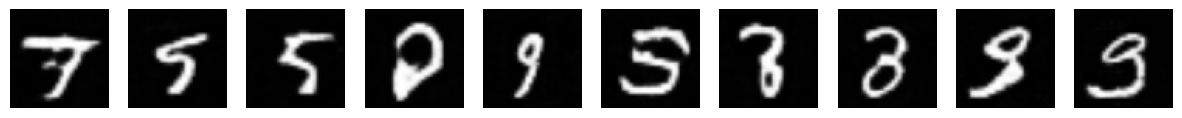

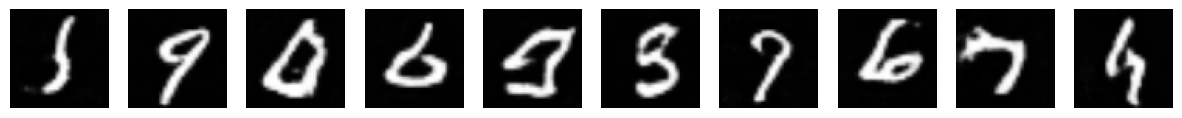

In [7]:
def train_wgan(generator, 
               discriminator, 
               generator_optimizer, 
               discriminator_optimizer, 
               dataloader,
               weight_clip=0.01,
               n_critic=5,
               epochs=200,
               device="cpu", 
               plot_generation_freq=50,
               plot_loss_freq=20,
               num_gens=10):

    gen_losses, disc_losses = [], []
    
    for epoch in tqdm(range(epochs)):
        
        for idx, (images, _) in enumerate(dataloader):
    
            batch_size = images.shape[0]
    
            ### These are our real images!! ###
            images = images.to(device)
            
            ########################################################## 
            ################ TRAIN DISCRIMINATOR #####################
            ########################################################## 
            
            ### Sample noise for Generation ###
            noise = torch.randn(batch_size, latent_dimension, 1, 1, device=device)
    
            ### Generate Samples G(z) and Take Off Computational Graph ###
            generated_images = generator(noise).detach()

            ### Pass Generated and Real Images into Discriminator ###
            real_discriminator_pred = discriminator(images) 
            gen_discriminator_pred = discriminator(generated_images)

            ### Compute Discriminator Loss ###
            discriminator_loss = torch.mean(gen_discriminator_pred) - torch.mean(real_discriminator_pred)

            ### Update Discriminator ###
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            ### Clip Discriminator Weights for Lipschitz Continuous ###
            for param in discriminator.parameters():
                param.data.clamp_(-weight_clip, weight_clip)

            ########################################################## 
            ################## TRAIN GENERATOR #######################
            ########################################################## 

            ### Only update generator after n_critic steps ###
            if idx % n_critic == 0:
                
                ### Sample noise for Generation ###
                noise = torch.randn(batch_size, latent_dimension, 1, 1, device=device)
    
                ### Generate Images ###
                generated_images = generator(noise)
    
                ### Pass Into Discriminator (to fool) ###
                gen_discriminator_pred = discriminator(generated_images)
    
                ### Compute Generator Loss ###
                generator_loss = - torch.mean(gen_discriminator_pred)
    
                ### Update the Generator ###
                generator_optimizer.zero_grad()
                generator_loss.backward()
                generator_optimizer.step()

    
        if (epoch % plot_generation_freq == 0) or (epoch == epochs-1):
            generator.eval()
            with torch.no_grad():
                noise_sample = torch.randn(batch_size, latent_dimension, 1, 1, device=device)
                generated_imgs = generator(noise_sample).to("cpu")
        
                fig, ax = plt.subplots(1,num_gens, figsize=(15,5))
        
                for i in range(num_gens):
                    img = (generated_imgs[i].squeeze() + 1)/2
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].set_axis_off()
        
                plt.show()
                
            generator.train()

    return generator, discriminator

generator, discriminator = train_wgan(generator=generator, 
                                      discriminator=discriminator, 
                                      generator_optimizer=gen_optimizer, 
                                      discriminator_optimizer=disc_optimizer, 
                                      dataloader=trainloader,
                                      weight_clip=0.01,
                                      n_critic=5,
                                      epochs=200,
                                      device="cuda", 
                                      plot_generation_freq=40,
                                      plot_loss_freq=40)


### Gradient Penalty

Although weight clipping was an easy heuristic for limiting the change in our function, it obviously seems like a weird way to do it. Sure our weights are small, but the clipping is a hard threshold and can cause some of the following issues:

- **Weight saturation:** What if the weights want to be larger than 0.01 or less than -0.01? Well they will keep updating to those values and then just get clipped back again. This significantly hurts the models ability to learn interesting things
- **Vanishing Gradients:** We are still using backpropagation like always! But if all our weights are very small, then during chain-rule in backprop, we risk vanishing gradients. This further hurts our ability to train larger models in mixed precision!
- **Parameter Search:** What is the ideal clipping value? Hyperparameter search is never fun anyway

What is our alternative? We want a restriction on the change in the function, which is its gradient. Well we have autograd, so we can actually compute this gradient! Lets look back at what our Lipschitz Constraint was:

$$D(x)-D(y) \leq |x-y|$$

So first question, what is $x$ and $y$ in this case? $x$ can be our original data and $y$ can be some $x+\epsilon$. Then we know that $D(x) - D(x+\epsilon) \leq \epsilon$. To make this happen, what we can do is for every sample in our batch, go ahead and add some perturbation to the image. But what perturbation do we want?

Remember, our Critics goal is to estimate the lowest cost Wasserstein distance between two distributions. In our case our distributions are the real data distribution and the generated distribution. Therefore, we want to compute gradients of the discriminator along the path that connects the two distributions and ensure it is not too large. 

To visualize this, you can think of two cities with a bunch of different ways to get between then, such as side roads, highways, etc... The Wasserstein loss wants to estimate the transport plan that most optimally gets you from one city to another, and we use a neural network to parameterize this metric. What we want to do is basically check something like the speed limit, we need to make sure when transporting stuff, our car isn't moving too fast. Basically, our gradients along this road must be within some reasonable value. 

Therefore, what we can do is take a weighted average of our real and fake images like so:

$$ \text{Perturbation: } \alpha * real + (1-\alpha) * fake$$

We can random sample $\alpha$ between 0 and 1, and then take proportionate amounts of each image. 0 would be a completely fake image, 1 would be a completely real image, and 0.5 would be a half real/half fake image. We can then compute the derivative of the model between the outputs of our discriminator on the perturbed images and the perturbed images themselves. 

Now to enfore 1-Lipschitz, we have been looking at:

$$D(x)-D(y) \leq |x-y|$$

Which again means the change in the function is never mode than the change in the input. This would mean the slope of the function is always less than 1. Another way to describe this would be the following:

$$||\Delta D(x)|| \leq 1$$

This says that the magnitude of our gradient is always bounded by 1. Both are saything the same thing, just written differently. Therefore, our penalty can be written as taking the norm of our derivative and making sure its less than one!

This means our final gradient penalty looks like this:

$$(||\Delta D(x)|| -1)^2$$

Basically the square difference between the norm (which we want as 1) and 1

### How do we Take a Derivative?

We will be using ```torch.autograd.grad``` which is a way to explicitly compute gradients in PyTorch. It looks a bit like this:

```python
torch.autograd.grad(outputs, 
                    inputs, 
                    grad_outputs=None, 
                    retain_graph=False, 
                    create_graph=False,)

```

You can image this as computing the derivative of the output w.r.t the input. 

We also have the following arguments:

- **grad_outputs**: When doing backprop we take the derivative of a deeper part of the model and send it backwards for chain rule with an earlier part. If for some reason when manually computing the derivative here, we had some upstream gradient coming in (imagine we were doing this operation in the middle of our model somewhere), then we could pass them in here. We will be working on the output of the Critic, so we don't have any upstream gradients. By default, if you leave this as None, it expects that the outputs is a scalar, and sets the grad_outputs to 1. If our outputs is not a scalar (like our case it'll be a batched tensor), we still want it to be 1, just a tensor of ones in the same shape as our output!
- **create_graph**: Just like everything in PyTorch we build a computational graph. We need this because we will be adding in our grad penalty loss, so we need that graph to backprop with!
- **retain_graph**: We want to hold onto the graph because we need it for our backprop calculation

Lets do an example!

$$y=x + 2$$
$$z = y^2 * 3$$

We know that $\dfrac{dz}{dx} = 18$ at $x=1$

In [30]:
x = torch.ones(1, requires_grad=True)
y = x + 2
z = y**2 * 3

z.backward()
print("dz/dx Gradient")
print(x.grad.sum())

dz/dx Gradient
tensor(18.)


What about an intermediate derivative like $\dfrac{dy}{dx}$ or $\dfrac{dz}{dy}$

Well, we know what they should be:

$$\dfrac{dy}{dx} = 1$$
$$\dfrac{dz}{dy} = 6$$

In [31]:
dy_dx = torch.autograd.grad(outputs=y, inputs=x)

print("dy/dx Gradient")
print(dy_dx)

dy/dx Gradient
(tensor([1.]),)


In [32]:
dz_dy = torch.autograd.grad(outputs=z, inputs=y)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

### A Bug?

No! This is just how PyTorch works. So lets look again and see. Previously we already ran ```z.backward()```. This used the computational graph that was automatically built via the AutoGrad engine, but once we called ```.backward``` this graph was removed as its no longer necessary (sames some compute and memory). 

Well we just called:

```python
dz_dy = torch.autograd.grad(outputs=z, inputs=y)
```
This would need the computational graph from ```z``` to go back to y, but we just deleted it by doing ```.backward```. So to make this work, we need to add in our ```.backward(retain_graph=True)``` which is False by default. This is also the case when using ```torch.autograd.grad```, it will automatically clear the graph unless we tell it not to!

In [33]:
x = torch.ones(1, requires_grad=True)
y = x + 2
z = y**2 * 3

z.backward(retain_graph=True)
print("dz/dx Gradient")
print(x.grad.sum())
dy_dx = torch.autograd.grad(outputs=y, inputs=x)
dz_dy = torch.autograd.grad(outputs=z, inputs=y)

print("dy/dx Gradient")
print(dy_dx)

print("dz/dy Gradient")
print(dz_dy)


dz/dx Gradient
tensor(18.)
dy/dx Gradient
(tensor([1.]),)
dz/dy Gradient
(tensor([18.]),)


And as expected by chain rule, our full $\dfrac{dz}{dx} = \dfrac{dz}{dy}\dfrac{dy}{dx}$

## Lets Build WGAN with Gradient Penalty! 

We will again be following the implementation of the [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028v3) and there are a few details here:

- Better results with the Adam Optimizer and using beta1 = 0, beta2 = 0.9
- No Batchnormalization in the Discriminator (Critic)

### Update the Discriminator 

First, lets just remove the batchnorms from our discriminator! The reason batchnorm doesnt work out so well is it will mess with our 1-Lipschitz constraint. Before, we just clipped our weights so we didn't really care, but now we need the model to impose this constraint on itself through backpropagation and our gradient penalty. 

Now remember, the 1-Lipschitz constraint needs to be met for all samples and their perturbations. Batchnorm will scale and shift the activations in a way that is dependent on the batch itself, and can mess with our gradients in unpredictable ways. Its not that it cant work, its just it isn't ideal. So instead, we can either not normalize at all, or normalize per sample

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/dl_normalizations.png?raw=true" alt="drawing" width="800"/>

Here are your typical options for normalization. Notice that batchnorm will normalize across the batch $N$ which we want to avoid. So our options then are Layer Norm, Instance Norm or Group Norm. Layer norm will normalize (per sample) across all channels and spatial dimensions. Instance Norm will normalize across (per sample) across the spatial dimension, but each channel idependently. 

Layernorm could technically reduce the models ability to distinguish fine channel features as it averages across them, but is good for stabilizing training. On the other hand, Instance norm will normalize each channel separately so we won't loose any channel-specific information, but can be noisier. Everything is a tradeoff, but you will have to experiment to see what works best!

In [34]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):  # Match this to your dataset
        super().__init__()

        self.discriminator = nn.Sequential(

            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

        )

        self.apply(_init_weights)

    def forward(self, x):
        return self.discriminator(x).view(-1, 1)  # Flatten to (B x 1)

### Define the Gradient Penalty

Lets write a separate function to calculate our gradient penalty!

In [35]:
def compute_gradient_penalty(critic, real, fake):

    ### Create Blended Images And Ensure Gradients Are On ###
    alpha = torch.rand(real.shape[0], 1, 1, 1, device=real.device)
    blended = alpha * real + (1 - alpha) * fake
    blended.requires_grad_(True)

    ### Pass To Our Critic ###
    out = critic(blended)

    ### Compute dout/dblended ###
    gradients = torch.autograd.grad(
        outputs=out,
        inputs=blended,
        grad_outputs=torch.ones_like(out),
        create_graph=True,
        retain_graph=True
    )[0]

    ### Flatten Gradients on blended from (B x C x H x W) -> (B x C*H*W)
    gradients = gradients.view(gradients.shape[0], -1)

    ### Compute the Norm and Loss ###
    gradient_norm = gradients.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return penalty

### Training Script

Basically the same, just the gradient penalty is added in!

  0%|          | 0/200 [00:00<?, ?it/s]

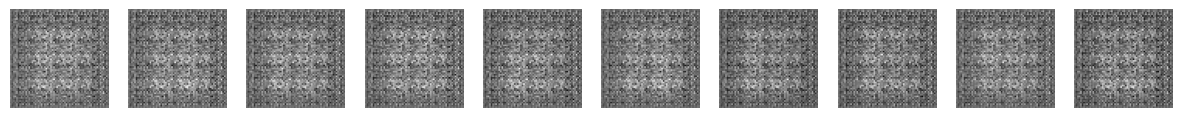

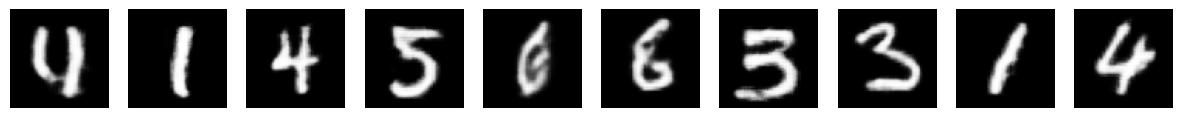

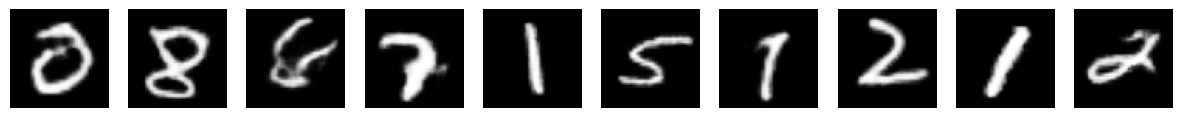

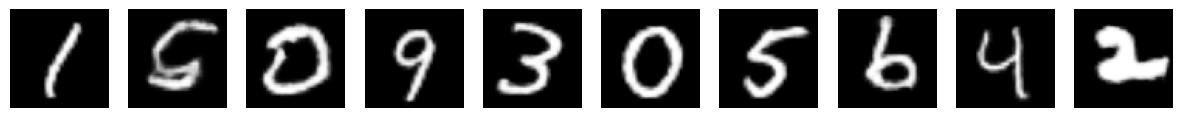

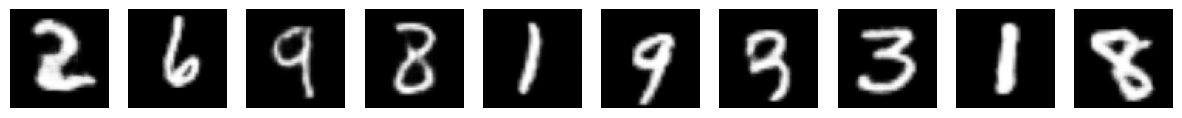

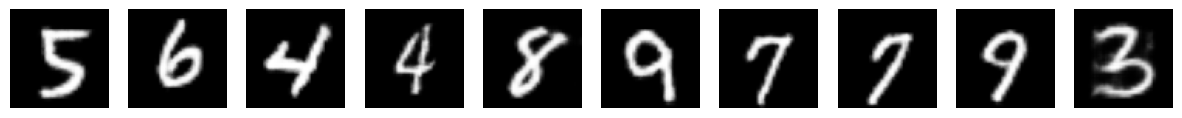

In [36]:
def train_wgan_gp(generator, 
                  discriminator, 
                  generator_optimizer, 
                  discriminator_optimizer, 
                  dataloader,
                  n_critic=5,
                  grad_penalty_weight=10,
                  epochs=200,
                  device="cpu",
                  plot_generation_freq=50,
                  plot_loss_freq=20,
                  num_gens=10):
    
    for epoch in tqdm(range(epochs)):
        
        for idx, (images, _) in enumerate(dataloader):
            batch_size = images.shape[0]
            images = images.to(device)
            
            # Train Discriminator
            discriminator_optimizer.zero_grad()
            
            noise = torch.randn(batch_size, latent_dimension, 1, 1, device=device)
            generated_images = generator(noise).detach()
            
            real_pred = discriminator(images)
            fake_pred = discriminator(generated_images)
            
            disc_loss = torch.mean(fake_pred) - torch.mean(real_pred)
            gp = compute_gradient_penalty(discriminator, images, generated_images)
            
            total_disc_loss = disc_loss + grad_penalty_weight * gp
            total_disc_loss.backward()
            discriminator_optimizer.step()
    
            if idx % n_critic == 0:
                
                generator_optimizer.zero_grad()
                
                noise = torch.randn(batch_size, latent_dimension, 1, 1, device=device)
                generated_images = generator(noise)
                gen_pred = discriminator(generated_images)
                
                gen_loss = -torch.mean(gen_pred)
                gen_loss.backward()
                generator_optimizer.step()
        
        if (epoch % plot_generation_freq == 0) or (epoch == epochs-1):
            generator.eval()
            
            with torch.no_grad():
                noise = torch.randn(num_gens, latent_dimension, 1, 1, device=device)
                generated_imgs = generator(noise).cpu()
                
                fig, ax = plt.subplots(1, num_gens, figsize=(15,5))
                for i in range(num_gens):
                    img = (generated_imgs[i].squeeze() + 1) / 2
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].axis('off')
                plt.show()
                
            generator.train()
    
    return generator, discriminator
    
generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001

### Define Models ###
generator = Generator(out_channels=1, in_channels_latent_dim=latent_dimension).to(device)
discriminator = Discriminator(in_channels=1).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=generator_learning_rate, betas=(0.0, 0.9))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=discriminator_learning_rate, betas=(0.0, 0.9))

generator, discriminators = train_wgan_gp(generator=generator,
                                          discriminator=discriminator,
                                          generator_optimizer=gen_optimizer,
                                          discriminator_optimizer=disc_optimizer,
                                          dataloader=trainloader,
                                          n_critic=5,
                                          grad_penalty_weight=10,
                                          epochs=200,
                                          device=device,
                                          plot_generation_freq=40)

### And that it!

We have covered most of the important ideas surrounding Wasserstein GAN! This was a really cool idea that I really wanted to cover, and covered a lot of important ideas that come later.